In [1]:
import sys
import os.path as op
# set path to SpectralEvents if necessary
#sys.path.append('/home/ryan/SpectralEvents')

import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns

import spectralevents_functions as se

sns.set()

In [3]:
numSubj = 10

eventBand = [15, 29]      # Frequency range of spectral events
fVec = np.arange(1, 60 + 1)            # Vector of fequency values over which to calculate TFR
Fs = 600                            # Sampling rate of time-series
findMethod = 1                      # Event-finding method (1 allows for maximal overlap while 2 limits overlap in each respective suprathreshold region)
width = 7
thrFOM = 6; # Factors of Median threshold (see Shin et al. eLife 2017 for details concerning this value)

################################
# Processing starts here
subjectIDs = np.arange(numSubj) + 1

# Load data sessions/subjects from the same experimental setup so that
# spectral event features are differentially characterized only between the
# desired trial classification labels: in this case, detection vs.
# non-detection
#
# Note: each .mat file contains:
#   'prestim_raw_yes_no' - 200 trials x 600 time samples matrix of time series data
#   'YorN' - 200 trials x 1 matrix of 1s or 0s to indicate trial label
x = list()
for s in subjectIDs:
    testFile = op.join('test_data', "".join(['prestim_humandetection_600hzMEG_subject',
                                             str(s), '.mat']))
    a = io.loadmat(testFile)
    x.append(a)

numTrials, numSamples = a['prestim_raw_yes_no'].shape

In [4]:
x[0]['YorN'].T

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]], dtype=uint8)

In [5]:
# Validate fVec input
Fn = Fs / 2                   # Nyquist frequency
dt = 1 / Fs                   # Sampling time interval
Fmin = 1 / (numSamples * dt)  # Minimum resolvable frequency

if fVec[0] < Fmin:
    sys.exit('Frequency vector includes values outside the resolvable/alias-free range.')
elif fVec[-1] > Fn:
    sys.exit('Frequency vector includes values outside the resolvable/alias-free range.')
elif np.abs(fVec[1] - fVec[0]) < Fmin:
    sys.exit('Frequency vector includes values outside the resolvable/alias-free range.')

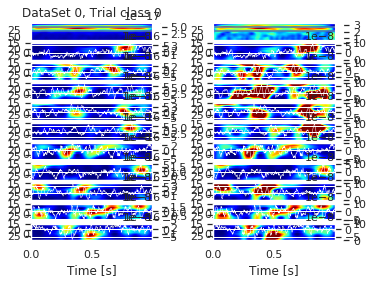

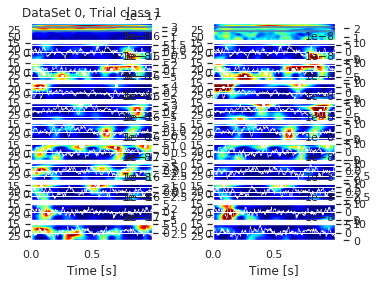

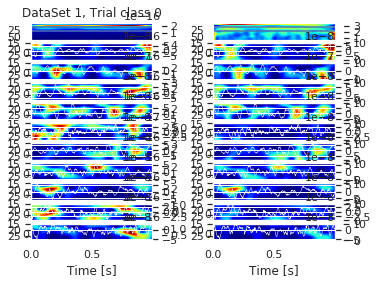

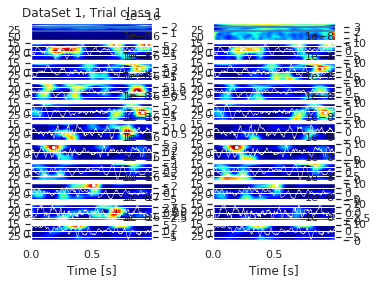

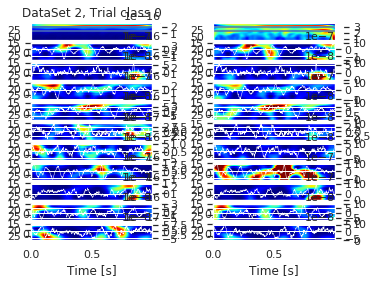

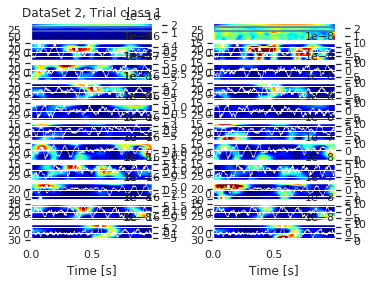

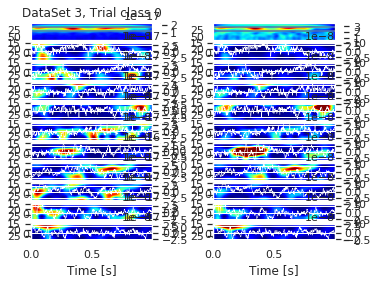

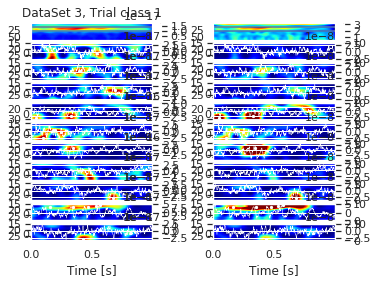

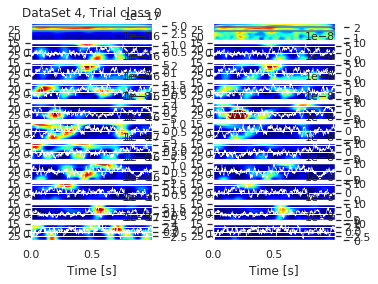

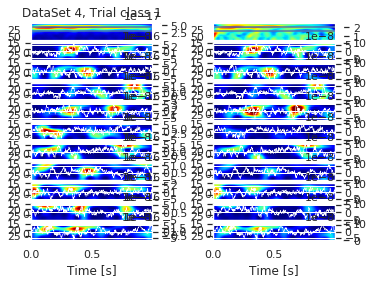

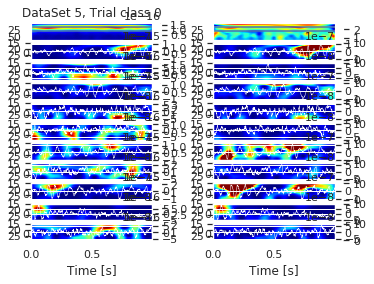

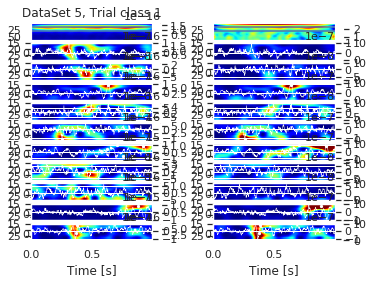

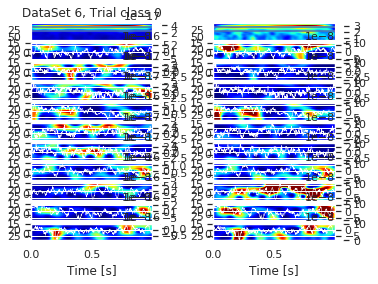

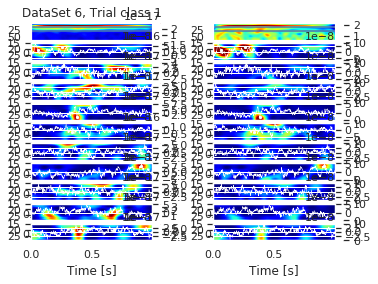

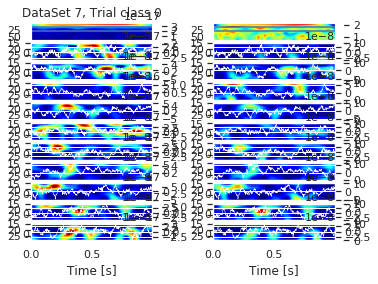

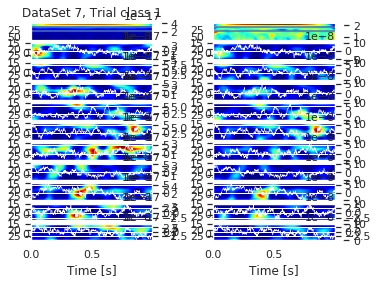

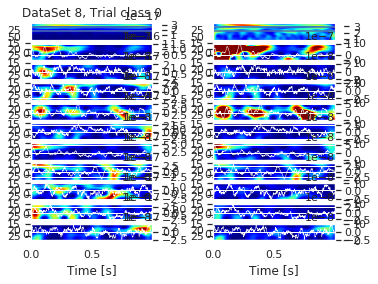

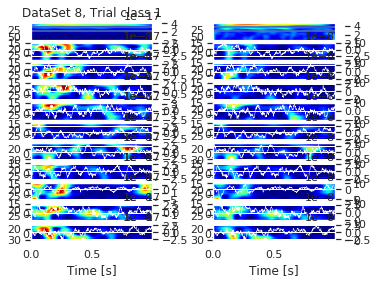

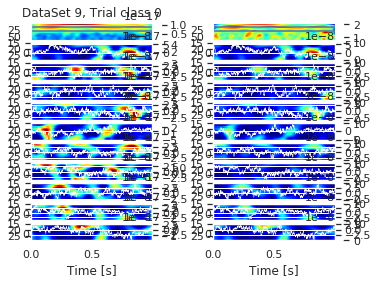

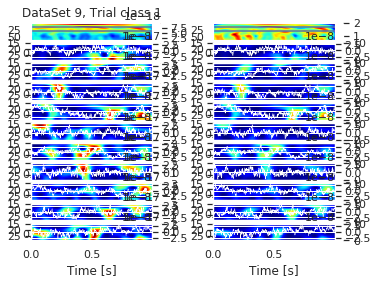

In [6]:
# Run spectral event analysis per dataset (Dataset loop)
TFR = list()
specEvents = list()
ctr = 1
for subj_idx, thisX in enumerate(x):

    # Convert data to TFR
    thisData = thisX['prestim_raw_yes_no']
    thisClassLabels = thisX['YorN'].squeeze()
    thisTFR, tVec, fVec = se.spectralevents_ts2tfr(thisData.T, fVec, Fs, width)
    TFR.append(thisTFR)

    # Normalize the TFR data [tr x f x t] to the median value per frequency band
    numTrials, numFreqBins, numSamples = thisTFR.shape
    TFR_order = np.transpose(thisTFR, axes=[1, 0, 2])  # [f x tr x t]
    TFR_reshape = np.reshape(TFR_order, (numFreqBins, numTrials * numSamples))
    TFRmeds = np.median(TFR_reshape, axis=1)  # f vector
    TFRmeds_expanded = np.transpose(np.tile(TFRmeds, (numSamples, numTrials,1)), axes=[1, 2, 0])
    thisTFR_norm = thisTFR/TFRmeds_expanded

    # Find local maxima in TFR
    thisSpecEvents = se.find_events(eventBand, thrFOM, tVec, fVec, thisTFR, Fs)
    #thisSpecEvents = pd.DataFrame( thisSpecEvents )
    specEvents.append(thisSpecEvents)

    # Extract event attributes for this test data
    classes = np.unique(thisClassLabels)

    # Plot results for each class of trial
    for clss in classes:

        # Get TFR, time course, and trial IDs for this class of trials only
        trial_inds = np.nonzero(thisClassLabels == clss)[0]
        classTFR = thisTFR[trial_inds, :, :]
        classTFR_norm = thisTFR_norm[trial_inds, :, :]
        classData = thisData[trial_inds, :]

        # Get events data for this class only, and update trial indices to be consecutive
        #   starting at 0
        event_trials = [(event['Trial'] in trial_inds) for event in thisSpecEvents]
        classEvents = thisSpecEvents[event_trials]

        # Make figure
        fig, axs = se.plot_avg_spectrogram(classEvents, classData, classTFR,
                                           classTFR_norm, tVec, fVec,
                                           eventBand)
        # Add title
        axs[0, 0].set_title('DataSet ' + str(subj_idx) + ', Trial class ' + str(clss))